In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ['KERAS_BACKEND']='tensorflow'

In [3]:
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.layers import Input, Lambda
from keras import backend as K

Using Theano backend.


In [4]:
K.backend(), K.image_data_format()

('theano', 'channels_last')

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
import cv2

%matplotlib inline

In [62]:
def open_img_as_x(filename):
    img = Image.open(filename)
    img = np.asarray(img)
    x = cv2.resize(img, dsize=(224, 224))
    x = x[None, :, :, :3].astype(np.float32) * 1.0/255.0
    return x

In [63]:
x = open_img_as_x('dog.jpg')

In [8]:
vgg = VGG16()

In [9]:
# # No normalization
# y_pred = vgg.predict_on_batch(x)
# print(decode_predictions(y_pred))

# def _vgg_preprocess_th(x):
#     x = 255.0 * x - vgg_mean_th
#     return x


# def _vgg_preprocess_tf(x):
#     x = 255.0 * x - vgg_mean_tf
#     return x

vgg_mean_th = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3, 1, 1))
vgg_mean_tf = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1, 1, 3))

# # With normalization, no rgb -> bgr
# y_pred = vgg.predict_on_batch(_vgg_preprocess_tf(x))
# print(decode_predictions(y_pred))

In [10]:
def vgg_preprocess_th(x):
    x = 255.0 * x - vgg_mean_th
    return x[:, ::-1]  # reverse axis rgb->bgr


def vgg_preprocess_tf(x):
    x = 255.0 * x - vgg_mean_tf
    return x[:, :, :, ::-1]  # reverse axis rgb->bgr

In [11]:
# With normalization with rgb -> bgr
y_pred = vgg.predict_on_batch(vgg_preprocess_tf(x))

decode_predictions(y_pred)

[[('n02113023', 'Pembroke', 0.85729599),
  ('n02113186', 'Cardigan', 0.13754605),
  ('n02085620', 'Chihuahua', 0.0037144977),
  ('n02109961', 'Eskimo_dog', 0.00051112764),
  ('n02115641', 'dingo', 0.00027459249)]]

In [67]:
# input_shape = (224, 224, 3)
# input_tensor = Input(input_shape)
# input_tensor = Lambda(vgg_preprocess_tf,
#                input_shape=input_shape, output_shape=input_shape,
#                name='vgg_preprocess')(input_tensor)
# vgg = VGG16(input_tensor=input_tensor)

# With normalization with rgb -> bgr
y_pred = vgg.predict_on_batch(x)

decode_predictions(y_pred)

[[('n03291819', 'envelope', 0.21566173),
  ('n04209239', 'shower_curtain', 0.19349094),
  ('n03598930', 'jigsaw_puzzle', 0.15032804),
  ('n04116512', 'rubber_eraser', 0.095183685),
  ('n03485794', 'handkerchief', 0.092721969)]]

In [12]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [13]:
from visu_utils import compute_layer_outputs

In [15]:
print([l.name for l in vgg.layers])

['input_2', 'vgg_preprocess', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


In [16]:
layer_output_f_dict = {}

In [64]:
x = open_img_as_x('map.png')

In [65]:
layer_names=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']
layer_outputs = compute_layer_outputs(x, vgg, layer_output_f_dict, layer_names=layer_names)

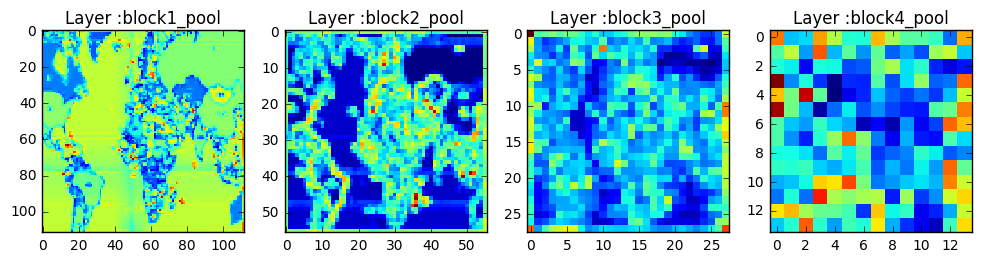

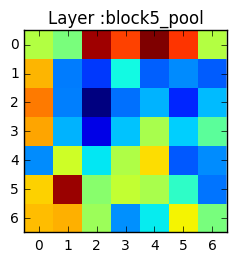

In [66]:
n = 4
for i, name in enumerate(layer_names):
    img = layer_outputs[name]
    img = np.max(img[0, :, :, :], axis=2)
    if i % n == 0:
        plt.figure(figsize=(12,4))
    plt.subplot(1, n, i % n + 1)
    plt.imshow(img, interpolation='none')
    plt.title('Layer :' + name)

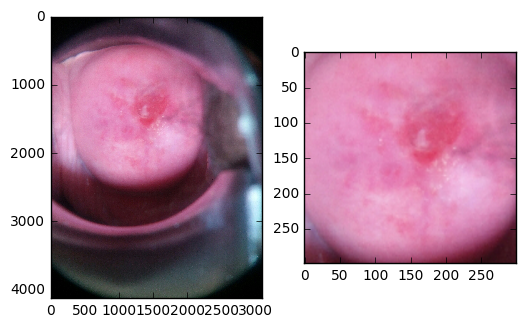

In [42]:
from image_utils import get_image_data, get_cervix_image
key = ('34', 'Type_1')
img1 = get_image_data(*key)
img2 = get_cervix_image(*key)
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)

In [31]:
for img in [img1, img2]:
    x = cv2.resize(img, dsize=(224, 224))
    x = x[None, :, :, :].astype(np.float32) * 1.0/255.0
    print(x.dtype, x.shape, x.min(), x.max())    
    y_pred = vgg.predict_on_batch(x)
    print("Prediction: ", decode_predictions(y_pred))

float32 (1, 224, 224, 3) 0.0 1.0
Prediction:  [[('n03676483', 'lipstick', 0.1858108), ('n03314780', 'face_powder', 0.17631398), ('n03692522', 'loupe', 0.13756225), ('n03920288', 'Petri_dish', 0.085393324), ('n03187595', 'dial_telephone', 0.031254608)]]
float32 (1, 224, 224, 3) 0.0431373 0.972549
Prediction:  [[('n07768694', 'pomegranate', 0.35123539), ('n03676483', 'lipstick', 0.084128514), ('n03314780', 'face_powder', 0.060668267), ('n04116512', 'rubber_eraser', 0.029617799), ('n07753113', 'fig', 0.028637199)]]


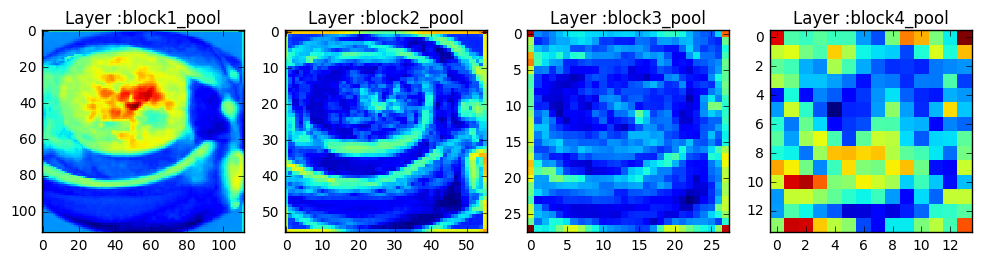

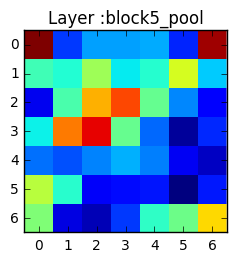

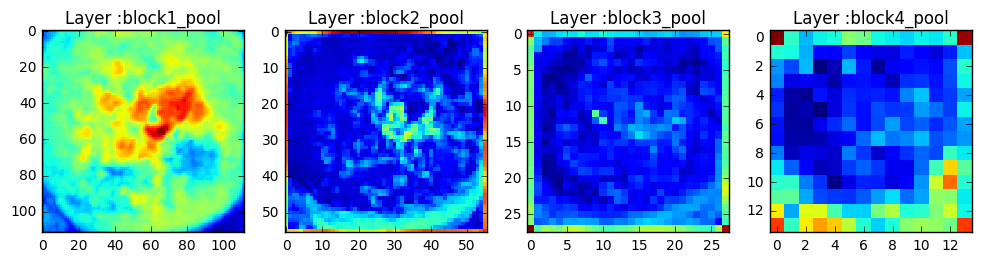

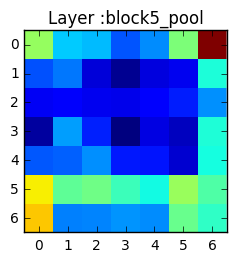

In [51]:
for img in [img1, img2]:
    x = cv2.resize(img, dsize=(224, 224))
    x = x[None, :, :, :].astype(np.float32) * 1.0/255.0
    
    layer_outputs = compute_layer_outputs(x, vgg, layer_output_f_dict, layer_names=layer_names)
    n = 4
    for i, name in enumerate(layer_names):
        img = layer_outputs[name]
        img = np.max(img[0, :, :, :], axis=2)
        if i % n == 0:
            plt.figure(figsize=(12,4))
        plt.subplot(1, n, i % n + 1)
        plt.imshow(img, interpolation='none')
        plt.title('Layer :' + name)    

Trained VGG on imagenet as feature detector -> XGBoost

In [10]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import get_image_data

sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

Number of hand-made annotations:  4483
2839 1644
2821


[0.32825239276852181, 0.33002481389578164, 0.34172279333569655]

In [11]:
from xy_providers import DataCache
try:
    if cache is None:
        cache = DataCache(0)
except NameError:
    cache = DataCache(0)

In [12]:
from training_utils import get_train_gen_flow

In [13]:
seed = 54321

batch_size = 4

max_counter = (len(trainval_id_type_list) // batch_size) * batch_size * 3

X_trainval_sets = np.zeros((max_counter, 1000))
Y_trainval_sets = np.zeros((max_counter, 3), dtype=np.uint8)


input_shape = (224, 224, 3)
input_tensor = Input(input_shape)
input_tensor = Lambda(vgg_preprocess_tf,
               input_shape=input_shape, output_shape=input_shape,
               name='vgg_preprocess')(input_tensor)
vgg = VGG16(input_tensor=input_tensor)


trainval_gen, trainval_flow = get_train_gen_flow(trainval_id_type_list, 
                                                 normalize_data=False, 
                                                 normalization='', 
                                                 batch_size=batch_size, 
                                                 option='cervix', 
                                                 seed=seed, 
                                                 image_size=(224, 224), 
                                                 xy_provider_cache=cache, 
                                                 save_prefix='', 
                                                 verbose=0)


counter = 0
for (x, y) in trainval_flow:
    print("-- %i / %i" % (counter, max_counter))
    y_pred = vgg.predict_on_batch(x)
    X_trainval_sets[counter:counter+batch_size, :] = y_pred
    Y_trainval_sets[counter:counter+batch_size, :] = y
        
    counter += batch_size
    if counter == max_counter:
        break


-- 0 / 8460
-- 4 / 8460
-- 8 / 8460
-- 12 / 8460
-- 16 / 8460
-- 20 / 8460
-- 24 / 8460
-- 28 / 8460
-- 32 / 8460
-- 36 / 8460
-- 40 / 8460
-- 44 / 8460
-- 48 / 8460
-- 52 / 8460
-- 56 / 8460
-- 60 / 8460
-- 64 / 8460
-- 68 / 8460
-- 72 / 8460
-- 76 / 8460
-- 80 / 8460
-- 84 / 8460
-- 88 / 8460
-- 92 / 8460
-- 96 / 8460
-- 100 / 8460
-- 104 / 8460
-- 108 / 8460
-- 112 / 8460
-- 116 / 8460
-- 120 / 8460
-- 124 / 8460
-- 128 / 8460
-- 132 / 8460
-- 136 / 8460
-- 140 / 8460
-- 144 / 8460
-- 148 / 8460
-- 152 / 8460
-- 156 / 8460
-- 160 / 8460
-- 164 / 8460
-- 168 / 8460
-- 172 / 8460
-- 176 / 8460
-- 180 / 8460
-- 184 / 8460
-- 188 / 8460
-- 192 / 8460
-- 196 / 8460
-- 200 / 8460
-- 204 / 8460
-- 208 / 8460
-- 212 / 8460
-- 216 / 8460
-- 220 / 8460
-- 224 / 8460
-- 228 / 8460
-- 232 / 8460
-- 236 / 8460
-- 240 / 8460
-- 244 / 8460
-- 248 / 8460
-- 252 / 8460
-- 256 / 8460
-- 260 / 8460
-- 264 / 8460
-- 268 / 8460
-- 272 / 8460
-- 276 / 8460
-- 280 / 8460
-- 284 / 8460
-- 288 / 8460
-- 292

In [15]:
import numpy as np

In [17]:
np.savez_compressed('x_trainval_vgg.npz', x=X_trainval_sets)
np.savez_compressed('y_trainval_vgg.npz', y=Y_trainval_sets)

In [19]:
import xgboost as xgb

In [52]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials 

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


x_train, x_val, y_train, y_val = train_test_split(X_trainval_sets[:n_samples,:], 
                                                    Y_trainval_sets[:n_samples,:], 
                                                    test_size=0.3, 
                                                    random_state=seed)



def objective(params):

    print("Trial : params=", params)
    n_rounds = 2000
    y_train2 = np.argmax(y_train, axis=1)
    y_val2 = np.argmax(y_val, axis=1)
    dtrain = xgb.DMatrix(x_train, y_train2)
    dvalid = xgb.DMatrix(x_val, y_val2)
    
    clf = xgb.train(params, 
                    dtrain, 
                    num_boost_round=n_rounds, 
                    evals=[(dvalid, 'eval'), (dtrain, 'train')],
                    verbose_eval=False,
                    early_stopping_rounds=50)
    y_pred = clf.predict(dvalid)
    loss = log_loss(y_val, y_pred)
    print("loss:", loss)
    return{'loss':loss, 'status': STATUS_OK }


params = {
    'eta': hp.quniform('eta', 0.001, 0.05, 0.005),
    'gamma': 1.0,
    'max_depth': 3 + hp.randint('max_depth', 7),
    'min_child_weight': 1 + hp.randint('min_child', 10),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'silent': 1,
    'seed': seed
}

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

Trial : params= {'objective': 'multi:softprob', 'max_depth': 3, 'silent': 1, 'colsample_bytree': 0.8634053132940627, 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 54321, 'gamma': 1.0, 'eta': 0.045, 'subsample': 0.9534524780768878, 'min_child_weight': 2}
loss: 1.10883085927
Trial : params= {'objective': 'multi:softprob', 'max_depth': 5, 'silent': 1, 'colsample_bytree': 0.7912275768396665, 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 54321, 'gamma': 1.0, 'eta': 0.035, 'subsample': 0.6621048123317157, 'min_child_weight': 6}
loss: 1.09309362812
Trial : params= {'objective': 'multi:softprob', 'max_depth': 4, 'silent': 1, 'colsample_bytree': 0.5065889426117955, 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 54321, 'gamma': 1.0, 'eta': 0.025, 'subsample': 0.8539955126925873, 'min_child_weight': 5}
loss: 1.08313226232
Trial : params= {'objective': 'multi:softprob', 'max_depth': 9, 'silent': 1, 'colsample_bytree': 0.8988085761381739, 'eval_metric': 'mlogloss', 'num_class': 3, 'se

In [104]:
xgb_params = {
    'eta': 0.015,
    'gamma': 1.0,
    'max_depth': 7,
    'min_child_weight': 2,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'silent': 1,
    'seed': seed
}

n_samples = 2800
dtrain = xgb.DMatrix(X_trainval_sets[:n_samples,:], np.argmax(Y_trainval_sets[:n_samples,:], axis=1))

In [105]:
n_folds = 5 
cv_result = xgb.cv(xgb_params, 
                   dtrain=dtrain,
                   nfold=n_folds,       
                   stratified=True,
                   num_boost_round=2000, 
                   early_stopping_rounds=150,                   
                   verbose_eval=True, show_stdv=False)

[0]	train-mlogloss:1.08968	test-mlogloss:1.09678
[1]	train-mlogloss:1.08084	test-mlogloss:1.09496
[2]	train-mlogloss:1.07224	test-mlogloss:1.09343
[3]	train-mlogloss:1.06364	test-mlogloss:1.09175
[4]	train-mlogloss:1.05526	test-mlogloss:1.09011
[5]	train-mlogloss:1.04692	test-mlogloss:1.08862
[6]	train-mlogloss:1.03871	test-mlogloss:1.08704
[7]	train-mlogloss:1.03087	test-mlogloss:1.08571
[8]	train-mlogloss:1.02283	test-mlogloss:1.08425
[9]	train-mlogloss:1.01506	test-mlogloss:1.08265
[10]	train-mlogloss:1.00742	test-mlogloss:1.08112
[11]	train-mlogloss:0.999794	test-mlogloss:1.07976
[12]	train-mlogloss:0.992307	test-mlogloss:1.07853
[13]	train-mlogloss:0.984885	test-mlogloss:1.07716
[14]	train-mlogloss:0.977528	test-mlogloss:1.07578
[15]	train-mlogloss:0.970583	test-mlogloss:1.07456
[16]	train-mlogloss:0.963335	test-mlogloss:1.07339
[17]	train-mlogloss:0.9566	test-mlogloss:1.07237
[18]	train-mlogloss:0.949595	test-mlogloss:1.07117
[19]	train-mlogloss:0.942994	test-mlogloss:1.07017
[20

KeyboardInterrupt: 

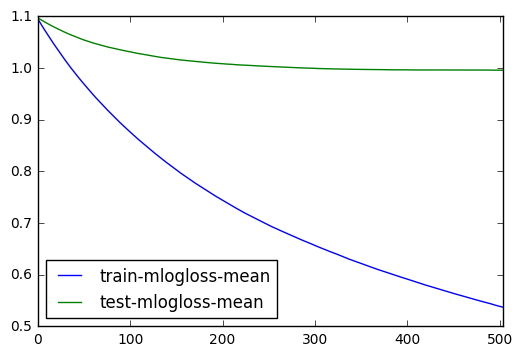

In [93]:
cv_result[['train-mlogloss-mean', 'test-mlogloss-mean']].plot()